![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [25]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [26]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

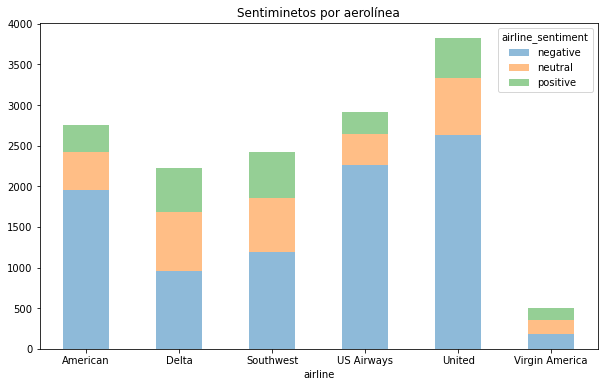

In [27]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import time

In [29]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

### Limpieza de datos (puntuacion y caracteres especiales)


In [30]:
import string
def clean(a_string):
    new_string = a_string.translate(str.maketrans('', '', string.punctuation))
    return new_string
X=X.apply(clean)
X

tweet_id
570306133677760513                     VirginAmerica What dhepburn said
570301130888122368    VirginAmerica plus youve added commercials to ...
570301083672813571    VirginAmerica I didnt today Must mean I need t...
570301031407624196    VirginAmerica its really aggressive to blast o...
570300817074462722    VirginAmerica and its a really big bad thing a...
                                            ...                        
569587686496825344    AmericanAir thank you we got on a different fl...
569587371693355008    AmericanAir leaving over 20 minutes Late Fligh...
569587242672398336    AmericanAir Please bring American Airlines to ...
569587188687634433    AmericanAir you have my money you change my fl...
569587140490866689    AmericanAir we have 8 ppl so we need 2 know ho...
Name: text, Length: 14640, dtype: object

In [31]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
# se crea una lista para guardar los accuracy de todos los modelos
accuracy=[]

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [33]:
# Celda 1
cv = CountVectorizer()
cv.fit(X)

CountVectorizer()

In [34]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Transformacion de documentos a matriz de terminos

In [35]:
x_train_vec = cv.transform(X_train)
x_test_vec = cv.transform(X_test)

### Entrenamiento del clasificador en train

In [36]:
start_time = time.time()
classifier = RandomForestClassifier().fit(x_train_vec, y_train)
classifier.fit(x_train_vec,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 22.222952604293823 seconds ---


In [37]:
y_pred_test = classifier.predict(x_test_vec)
accuracy.append(accuracy_score(y_test, y_pred_test))

In [38]:
# Accuracy del modelo Random Forest usando la función CountVectorizer
accuracy

[0.7663493377483444]

In [65]:
classes=['Negativo','Neutral','Positivo']
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()


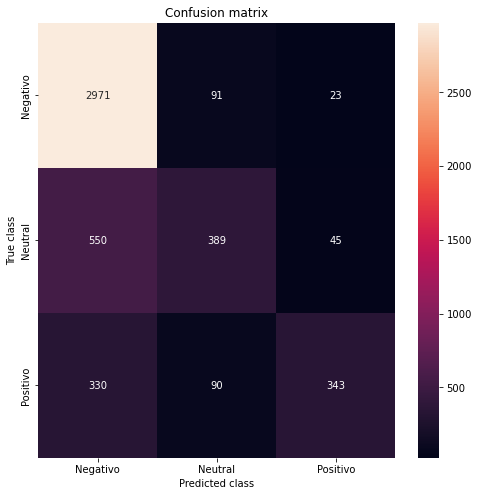

In [66]:
mostrar_resultados(y_test, y_pred_test)

### Conclusiones modelo Random Forest usando la función CountVectorizer

El modelo presenta un Accuracy moderado a alto **0.7663** , sin embargo de acuerdo con la matrix de confusión el modelo es muy bueno para predecir tweets negativos, pero en el caso de los tweets neutrales el modelo tiende a predecirlos en su mayoría como negativos y para el caso de los tweets positivos se predicen en casi igual proporción como tweets negativos y positivos, por lo que no es muy buena la predicción para los tweets neutrales y positivos.


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [67]:
# Celda 2
cv = CountVectorizer(stop_words="english")
cv.fit(X)

CountVectorizer(stop_words='english')

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Transformacion de documentos a matriz de terminos

In [69]:
x_train_vec = cv.transform(X_train)
x_test_vec = cv.transform(X_test)

### Entrenamiento del clasificador en train

In [70]:
start_time = time.time()
classifier = RandomForestClassifier().fit(x_train_vec, y_train)
classifier.fit(x_train_vec,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 27.257977962493896 seconds ---


In [71]:
y_pred_test = classifier.predict(x_test_vec)
accuracy.append(accuracy_score(y_test, y_pred_test))

In [74]:
# Accuracy del modelo Random Forest usando la función CountVectorizer y eliminando stopwords
accuracy[1]

0.7651076158940397

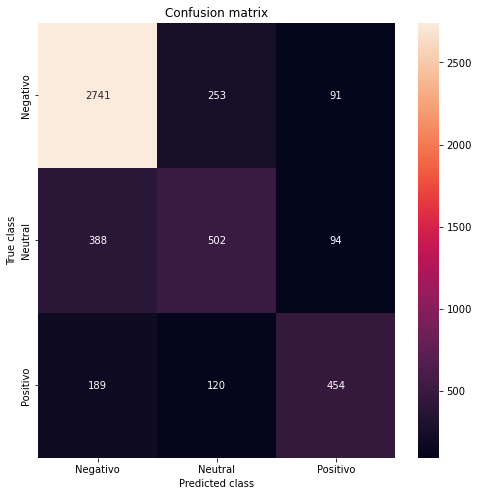

In [75]:
mostrar_resultados(y_test, y_pred_test)

### Conclusiones modelo Random Forest usando la función CountVectorizer y eliminando stopwords

El modelo presenta un Accuracy moderado a alto **0.7651** ligeramente inferior al modelo anterior, de acuerdo con la matrix de confusión el modelo es muy bueno para predecir tweets negativos, para el caso de los tweets neutrales el modelo tiende a predecirlos en su mayoría como neutrales y en esto mejora con respecto al modelo anterior, aunque se siguen prediciendo muchos neutrales como negativos y para el caso de los tweets positivos la mayoría se predicen como positivos y en esto mejora con respecto al modelo anterior significativamente, pero el primer modelo sigue siendo mucho mejor para predecir los tweets negativos que son los mas importantes en la predicción.


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [83]:
import nltk
nltk.download('punkt')

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t,'v') for t in word_tokenize(articles)]

[nltk_data] Downloading package punkt to /home/joan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [84]:
# Celda 3
cv = CountVectorizer(tokenizer=LemmaTokenizer())
cv.fit(X)

CountVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7f61fe385820>)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Transformacion de documentos a matriz de terminos

In [86]:
x_train_vec = cv.transform(X_train)
x_test_vec = cv.transform(X_test)

### Entrenamiento del clasificador en train

In [87]:
start_time = time.time()
classifier = RandomForestClassifier().fit(x_train_vec, y_train)
classifier.fit(x_train_vec,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 21.097259998321533 seconds ---


In [88]:
y_pred_test = classifier.predict(x_test_vec)
accuracy.append(accuracy_score(y_test, y_pred_test))

In [89]:
# Accuracy del modelo Random Forest usando la función CountVectorizer y lematizando el texto con verbos 
accuracy[2]

0.7669701986754967

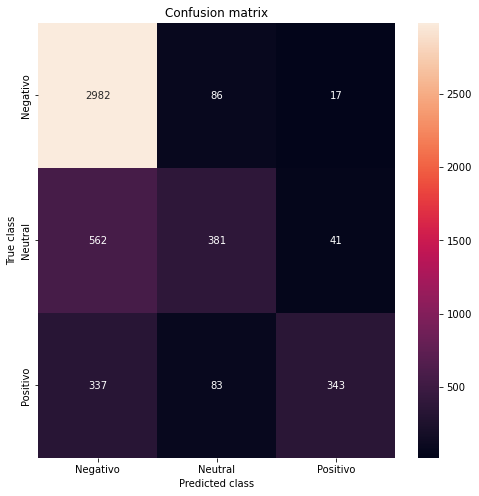

In [90]:
mostrar_resultados(y_test, y_pred_test)

### Conclusiones modelo Random Forest usando la función CountVectorizer y lematizando el texto con verbos 

El modelo presenta un Accuracy moderado a alto **0.7669** ligeramente mejor a los modelos anteriores, de acuerdo con la matrix de confusión el modelo es mejor que los modelos anteriores para predecir tweets negativos, para el caso de los tweets neutrales el modelo tiende a predecirlos en su mayoría como negativos y en esto no es mejor con respecto al modelo anterior y para el caso de los tweets positivos la mayoría se predicen como positivos, pero casi en la misma proporción se predicen como negativos y en esto no es mejor que el modelo anterior y se comporta muy similar al primer modelo, aunque este modelo es mucho mejor para predecir los tweets negativos que son los mas importantes en la predicción.


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [91]:
# Celda 4
cv = CountVectorizer(stop_words="english",tokenizer=LemmaTokenizer())
cv.fit(X)

CountVectorizer(stop_words='english',
                tokenizer=<__main__.LemmaTokenizer object at 0x7f61fe54b100>)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Transformacion de documentos a matriz de terminos

In [93]:
x_train_vec = cv.transform(X_train)
x_test_vec = cv.transform(X_test)

### Entrenamiento del clasificador en train

In [94]:
start_time = time.time()
classifier = RandomForestClassifier().fit(x_train_vec, y_train)
classifier.fit(x_train_vec,y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 25.68164896965027 seconds ---


In [95]:
y_pred_test = classifier.predict(x_test_vec)
accuracy.append(accuracy_score(y_test, y_pred_test))

In [96]:
# Accuracy del modelo Random Forest usando la función CountVectorizer,eliminando stopwords y lematizando el texto con verbos 
accuracy[3]

0.7620033112582781

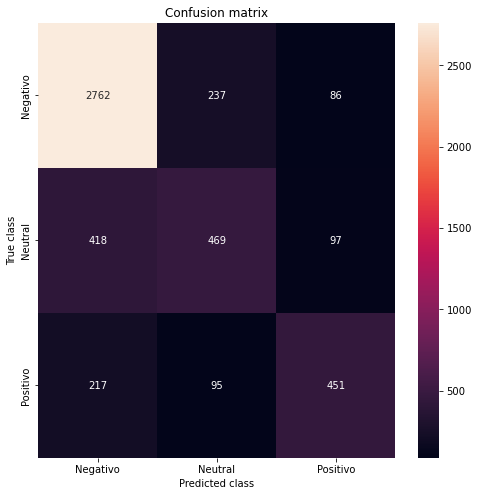

In [97]:
mostrar_resultados(y_test, y_pred_test)

### Conclusiones modelo Random Forest usando multiples técnicas 

El modelo presenta un Accuracy moderado a alto **0.7620** inferior a los modelos modelo anteriores, de acuerdo con la matrix de confusión el modelo es muy bueno para predecir tweets negativos, pero no mejor que el modelo anteiror, para el caso de los tweets neutrales el modelo tiende a predecirlos en su mayoría como neutrales y en esto mejora con respecto al modelo anterior, aunque se siguen prediciendo muchos neutrales como negativos y para el caso de los tweets positivos la mayoría se predicen como positivos y en esto mejora con respecto al modelo anterior significativamente, pero el modelo anterior sigue siendo mucho mejor para predecir los tweets negativos que son los mas importantes en la predicción.

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [98]:
accuracy

[0.7663493377483444,
 0.7651076158940397,
 0.7669701986754967,
 0.7620033112582781]

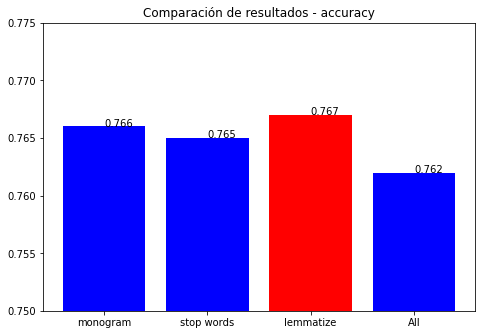

In [103]:
# Celda 5
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de resultados - accuracy")
ejeX = ['monogram','stop words','lemmatize','All']
ejeY = np.round(np.array(accuracy),3)
ax.bar(ejeX,ejeY,color=['blue',"blue","red","blue"])
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.ylim(0.75,0.775)
plt.show()

 ### Conclusiones 
* El modelo Random Forest usando la función CountVectorizer y lematizando el texto con verbos es el mejor modelo, la lematizacion ofrece un mejor desempeño en el modelo y con mejores resultados de predicción de tweets negativos que es el principal interes de las aerolineas para mejorar sus procesos y poder aplicar correctivos.
* Al eliminar los stopwords se observa una baja en el desempeño del modelo ubicandose casi a la par de incorporar todas las condiciones aplicadas (monogramas, stop words, lemmatize)
* Se esperaria que mezclando todas las variantes de analisis el accuracy mejorara pero no es asi, el mejor desempeño se logra con lematizacion
* Para todos los modelos los mejores resultados se obtienen prediciendo los tweets negativos y la diferencia en el Accuracy de los modelos es muy leve, pero usando la matriz de confusion se observa una diferencia marcada usando lematizacion que incrementa significativamente la prediccion de tweets negativos.
* Para el caso de los tweets neutrales y positivos el mejor modelo para predecir es el modelo Random Forest usando la función CountVectorizer y eliminando stopwords